In [1]:
import sys

import diffrax
import jax
import jax.numpy as jnp
import numpy as np
from pytensor.tensor.type import TensorType
import graphviz
import matplotlib.pyplot as plt

sys.path.append("../")
import comodi

/home/jdehning/mambaforge/envs/dev_env/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


In [2]:
def covid_model(t, y, arg):
    comp_model = comodi.CompModel(y)
    dy = {}

    # Effective spreading
    dy["hs"] = comodi.delayed_copy(y["H"], y["hs"], arg["tau"])
    h = y["hs"][-1]
    mitigation = arg["m_max"] - arg["m_max"] / arg["h_thres"] * arg[
        "epsilon"
    ] * jax.nn.softplus(1 / arg["epsilon"] * (arg["h_thres"] - h))
    seasonality = 1 + arg["a"] * jnp.cos(arg["omega_s"] * t)

    eff_spreading = arg["beta_0"] * (1 - mitigation) * seasonality

    # vaccination
    comp_model.flow("S", "V", arg["phi"], "phi")
    comp_model.flow("SW", "V", arg["phi"], "phi")
    # contagion
    contagion_factor = eff_spreading * (
        y["Ia"] + y["Is"] + arg["eta"] * (y["IWa"] + y["IWs"])
    )
    comp_model.flow(
        "S",
        "E",
        contagion_factor,
        r"beta * (Ia + Is + eta * (IWa + IWs))",
    )
    comp_model.flow(
        "SW",
        "EW",
        contagion_factor,
        "beta * (Ia + Is + eta * (IWa + IWs))",
    )

    # waning immunity
    comp_model.flow("SW", "S", arg["omega_w"], "omega_w")
    comp_model.flow("V", "SW", arg["omega_v"], "omega_v")
    comp_model.flow("R", "SW", arg["omega_r"], "omega_r")

    # infection progression E -> I
    comp_model.flow("E", "Is", arg["rho"] * arg["xi"], "rho * xi")
    comp_model.flow("E", "Ia", arg["rho"] * (1 - arg["xi"]), "rho * (1 - xi)")
    comp_model.flow(
        "EW",
        "IWs",
        arg["rho"] * arg["eta"] * arg["xi"],
        "rho * eta * xi",
    )
    comp_model.flow(
        "EW",
        "IWa",
        arg["rho"] * (1 - arg["xi"] * arg["eta"]),
        "rho * (1 - xi * eta)",
    )

    # Testing
    comp_model.flow(
        "Is", "Ts", arg["lambda_s"] + arg["lambda_r"], "lambda_s + lambda_r"
    )
    comp_model.flow("Ia", "Ta", arg["lambda_r"], "lambda_r")
    comp_model.flow(
        "IWs", "TWs", arg["lambda_s"] + arg["lambda_r"], "lambda_s + lambda_r"
    )
    comp_model.flow("IWa", "TWa", arg["lambda_r"], "lambda_r")

    # Hospitalization
    comp_model.flow("Is", "H", arg["delta"], "delta")
    comp_model.flow("IWs", "H", arg["eta"] * arg["delta"], "eta * delta")
    comp_model.flow("Ts", "H", arg["delta_star"], "delta_star")
    comp_model.flow("TWs", "H", arg["eta"] * arg["delta_star"], "eta * delta_star")

    # Death
    comp_model.flow("H", "D", arg["alpha"], "alpha")

    # Recovery
    comp_model.flow(["Is", "IWs", "Ia", "IWa"], "R", arg["gamma"], "gamma")
    comp_model.flow(["Ts", "TWs", "Ta", "TWa"], "R", arg["gamma_star"], "gamma_star")
    comp_model.flow("H", "R", arg["gamma_H"], "gamma_H")
    dy.update(comp_model.dy)
    #comp_model.view_graph()
    return dy

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


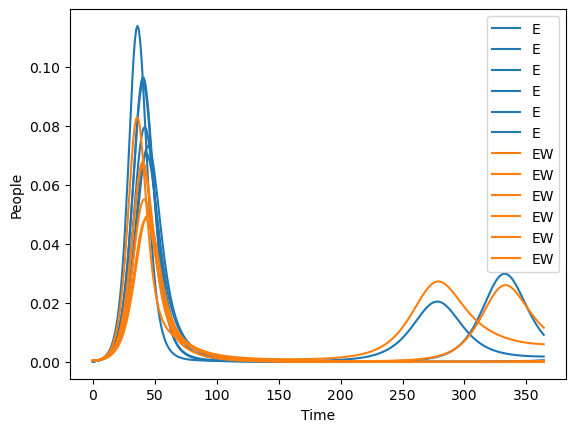

In [3]:

len_sim = 365

num_points = 365

num_age_groups = 6
N = 1e6

t_out = np.linspace(0, len_sim, num_points)
t_solve_ODE = np.linspace(0, len_sim, num_points//2)
t_beta = np.linspace(0, len_sim, num_points)



integrator = comodi.CompModelsIntegrator(
    ts_out=t_out,
    t_0=min(t_out),
    ts_solver=t_solve_ODE,#diffrax.PIDController(rtol=1e-2, atol=1e-3),
    interp="cubic",
    #solver=diffrax.Kvaerno5(nonlinear_solver=diffrax.NewtonNonlinearSolver(rtol=1e-2, atol=1e-4)),  
    solver=diffrax.Tsit5(),
    #adjoint=diffrax.RecursiveCheckpointAdjoint(checkpoints=len(t_solve_ODE)),
).get_func(covid_model)

@jax.jit
def simulation(x):
    
    y0 = {
        "V": 1000 / N,
        "SW": 500_000 / N,
        "E": 100 / N,
        "EW": 500 / N,
        "Is": 100 / N,
        "Ia": 100 / N,
        "IWs": 100 / N,
        "IWa": 100 / N,
        "Ts": 0,
        "Ta": 0,
        "TWs": 0,
        "TWa": 0,
        "H": 0,
        "D": 0,
        "R": 0,
        "hs": [0, 0],
    }
    y0["S"] = 1 - jax.tree_util.tree_reduce(lambda x, y: x + y, y0)
    y0 = jax.tree_map(lambda x: np.ones(num_age_groups)*x, y0)

    
    output = integrator(
        y0=y0, constant_args=x
    )

    return output

arg = {
    "beta_0": 0.5,
    "phi": 50 / N * np.array([0, 0, 0, 1, 1, 1]) / 6,  # vaccination rate
    "gamma": np.array([0.1, 0.1, 0.1, 0.09, 0.09, 0.09]),  # recovery rate
    "gamma_star": np.array(
        [0.1, 0.1, 0.1, 0.09, 0.09, 0.09]
    ),  # recovery rate from traced pool
    "gamma_H": np.array(
        [0.194, 0.192, 0.0847, 0.0814, 0.0914, 0.0842]
    ),  # recovery rate from hospitalization
    "delta": np.array(
        [1.4e-5, 2.04e-4, 1.22e-3, 4.03e-3, 5.44e-3, 7.16e-3]
    ),  # hospitalization rate
    "delta_star": np.array(
        [1.4e-5, 2.04e-4, 1.22e-3, 4.03e-3, 5.44e-3, 7.16e-3]
    ),  # hospitalization rate from traced pool, same as delta?
    "alpha": np.array(
        [0.005560, 0.007780, 0.006164, 0.009508, 0.019756, 0.082433]
    ),  # death rate from hospitalization
    "xi": np.array([0.75, 1, 1, 1.1, 1.1, 1.2])
    * 0.68,  # symptomatic ratio of infections
    "lambda_s": np.array(
        [0.15, 0.25, 0.25, 0.4, 0.3, 0.3]
    ),  # rate of testing and self-isolating (symptomatic),
    "lambda_r": np.zeros(num_age_groups),  # rate of testing and self-isolating (random)
    "eta": np.ones(num_age_groups) / 3,  # antibody protection against severe course
    "omega_r": np.ones(num_age_groups)
    / 180,  # rate of waning (natural) immunity against infection
    "omega_v": np.ones(num_age_groups)
    / 180,  # rate of waning (vaccine) immunity against infection
    "omega_w": np.ones(num_age_groups)
    / 180,  # rate of waning (both) immunity against severe course
    "rho": np.ones(num_age_groups) * 0.25,  # transition rate from E to I
    "tau": np.ones(num_age_groups) * 60,  # mitigation delay
    "m_max": np.ones(num_age_groups) * 0.2,  # maximum mitigation
    "h_thres": np.ones(num_age_groups) * 5e-5,  # threshold hazard
    "a": 0.2,  # seasonal amplitude
    "omega_s": 2 * np.pi / 365,  # seasonal frequency
    "epsilon": 1 / 4000,  # feedback curvature
}
def tot_death(x):
    return jnp.sum(simulation(x)['D'][-1])

output = simulation(arg)
plt.plot(output["E"], color='tab:blue', label="E")
plt.plot(output["EW"], color='tab:orange', label="EW")
plt.xlabel('Time')
plt.ylabel('People')
plt.legend()

In [4]:
# Time

%timeit simulation(arg)["E"].block_until_ready()


2.66 ms ± 41.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:

grad = jax.jit(jax.grad(tot_death))
%timeit grad(arg)["beta_0"].block_until_ready()


18.3 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
